In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv('E:\IOT-Project\cleaned_Phishing.csv')  # Adjust the path as needed

In [2]:
# Assuming 'Result' is your target column
X = df.drop(columns=['Result'])  # Features
y = df['Result']  # Target variable

In [3]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print('Shape of X_train and X_test:', X_train.shape, X_test.shape)
print('Shape of y_train and y_test:', y_train.shape, y_test.shape)

Shape of X_train and X_test: (8844, 36) (2211, 36)
Shape of y_train and y_test: (8844,) (2211,)


In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'sparse_categorical_crossentropy' for multi-class
              metrics=['accuracy'])

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

In [8]:
# Train the model with EarlyStopping
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/30


222/222 [==============================] - 2s 2ms/step - loss: 0.2670 - accuracy: 0.8930 - val_loss: 0.1485 - val_accuracy: 0.9423
Epoch 2/30
222/222 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.9471 - val_loss: 0.1332 - val_accuracy: 0.9435
Epoch 3/30
222/222 [==============================] - 0s 1ms/step - loss: 0.1156 - accuracy: 0.9528 - val_loss: 0.1144 - val_accuracy: 0.9486
Epoch 4/30
222/222 [==============================] - 0s 1ms/step - loss: 0.1014 - accuracy: 0.9566 - val_loss: 0.1160 - val_accuracy: 0.9474
Epoch 5/30
222/222 [==============================] - 0s 1ms/step - loss: 0.0919 - accuracy: 0.9610 - val_loss: 0.1044 - val_accuracy: 0.9559
Epoch 6/30
222/222 [==============================] - 0s 1ms/step - loss: 0.0838 - accuracy: 0.9635 - val_loss: 0.0999 - val_accuracy: 0.9542
Epoch 7/30
222/222 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9673 - val_loss: 0.0991 - val_accuracy: 0.9553
Epoc

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2368      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

70/70 [==============================] - 0s 935us/step - loss: 0.0955 - accuracy: 0.9661
Test Loss: 0.0955, Test Accuracy: 0.9661


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Assuming y_test contains your true labels
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9661


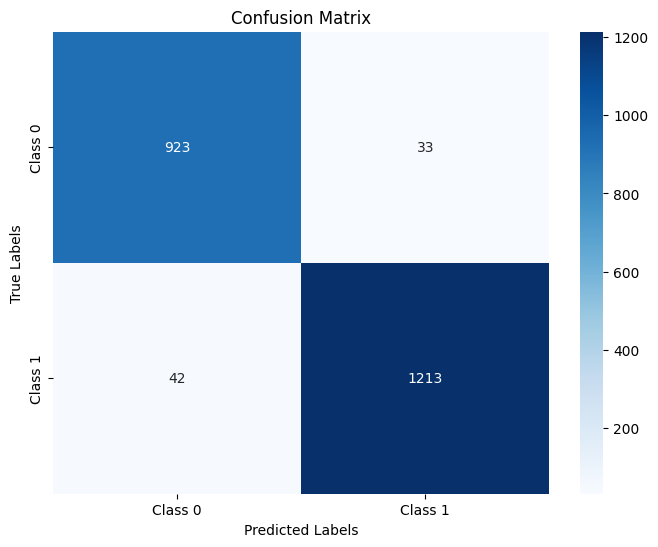

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Generate classification report
report = classification_report(y_test, predicted_classes, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.96       956
     Class 1       0.97      0.97      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.96      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



In [18]:
# Make predictions
predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')  # Print accuracy with 4 decimal places


70/70 [==============================] - 0s 1ms/step
Accuracy: 0.9661


In [19]:
model.save('Website_ClassifyModel.h5')

C:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
def representative_dataset():
    for _ in range(100):
      data =  X_test
      yield [data.astype(np.float32)]
        
print(representative_dataset())

<generator object representative_dataset at 0x000001F51FB3C9E0>


In [21]:
import tensorflow as tf

# Save the trained Keras model
tf.saved_model.save(model, "saved_phishing_model_keras_dir")

INFO:tensorflow:Assets written to: saved_phishing_model_keras_dir\assets


INFO:tensorflow:Assets written to: saved_phishing_model_keras_dir\assets


In [22]:
import numpy as np

def representative_dataset_gen():
    for input_value in representative_data:  # Replace with your actual representative data
        yield [input_value.astype(np.float32)]  # Ensure the correct data type


In [25]:
# Converting a tf.Keras model to a TensorFlow Lite model.
# It is preferred to use TFLiteConverter from saved model and then
# Also provide representative dataset to train the converted TFLite model
# Avoid calling the TFLite converter directly from model
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

tf.saved_model.save(model, "saved_website_seq_model_keras_dir")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_website_seq_model_keras_dir")

# Though its size is not much, optimizer is used here to check whether it works on ESP32
# if this is chosen, tf.lite.Optimize.OPTIMIZE_FOR_SIZE, the TFLite does not work on ESP32
# Observed that even with Optimize.DEFAULT the TFLite model does not work on ESP32
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_website_seq_model_keras_dir\assets


INFO:tensorflow:Assets written to: saved_website_seq_model_keras_dir\assets


In [26]:
# Save the model in TFlite format whose size is just 5 KB
# It brings down the size from 49.52 KB to 3.836 KB, 13 times reduction
with open('WebsiteClassifyModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [27]:
# Run the inference on TFLITE model on Python ... here itself first
# Let us now first try to run this tflinte model on Python itself
# Ref: https://www.tensorflow.org/lite/guide/inference
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="WebsiteClassifyModel.tflite")
interpreter.allocate_tensors()

In [28]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('input_details:\n', input_details)
print('output_details:\n', output_details)

input_details:
 [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 36]), 'shape_signature': array([-1, 36]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:
 [{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [35]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="WebsiteClassifyModel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input0_data = np.random.random_sample(input_shape)
input0_data = np.array(input0_data, dtype=np.float32)

# Set the input tensor to the random data
interpreter.set_tensor(input_details[0]['index'], input0_data)

# Invoke the model
interpreter.invoke()

# Get the output from the TFLite model
output0_data = interpreter.get_tensor(output_details[0]['index'])
print("TFLite model output for random input:")
print(output0_data)

# Verify the output with the original Keras model
output0_data_keras = model.predict(input0_data)
print("Original Keras model output for random input:")
print(output0_data_keras)

input1_data = [[0.0, 0.1, 0.2, 0.3, 0.0, 1.0, 0.0, 0.5, 0.7, 0.9, 
                 0.4, 0.8, 0.1, 0.6, 0.2, 0.3, 0.0, 1.0, 0.0, 
                 0.5, 0.7, 0.9, 0.4, 0.8, 0.1, 0.6, 0.2, 
                 0.3, 0.0, 1.0, 0.0, 0.5, 0.7, 0.9, 0.4,  # 35 features
                 0.5]]  # Add one more feature to make it 36

input2_data = [[1.0, 0.1, 0.2, 0.4, 0.3, 0.0, 0.2, 0.5, 0.8, 0.6, 
                 0.1, 0.3, 0.9, 0.0, 0.5, 0.8, 0.1, 0.0, 
                 0.3, 0.9, 0.6, 0.4, 0.7, 0.1, 0.3, 0.2, 
                 0.0, 1.0, 0.3, 0.4, 0.5, 0.6, 0.2, 0.1, 
                 0.0, 1.0]]  # Make sure this has 36 features

# Function to test individual inputs
def test_input(input_data, input_index):
    input_data = np.array(input_data, dtype=np.float32)

    # Print the shape of input_data for debugging
    print(f"Shape of input_data for input {input_index}: {input_data.shape}")
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Invoke the model
    interpreter.invoke()

    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f'TFLite model output for input {input_index}:')
    print(output_data)

    # Verify with the original Keras model
    output_data_keras = model.predict(input_data)
    print(f'Original Keras model output for input {input_index}:')
    print(output_data_keras)

# Test the specific inputs
test_input(input1_data, 1)
test_input(input2_data, 2)


TFLite model output for random input:
[[0.99609375]]
1/1 [==============================] - 0s 21ms/step
Original Keras model output for random input:
[[0.9996643]]
Shape of input_data for input 1: (1, 36)
TFLite model output for input 1:
[[0.99609375]]
1/1 [==============================] - 0s 16ms/step
Original Keras model output for input 1:
[[0.99968046]]
Shape of input_data for input 2: (1, 36)
TFLite model output for input 2:
[[0.99609375]]
1/1 [==============================] - 0s 19ms/step
Original Keras model output for input 2:
[[0.99985445]]
